# Notebook Overview

This notebook implements a full pipeline for preparing telecom-specific QA datasets, fine-tuning a LLaMA-2 model with LoRA adapters, and evaluating model performance. The workflow proceeds through the following stages:

Dataset Preprocessing and Filtering

Parse raw JSONL data into context–question–answer triples.

Apply semantic chunking using SentenceTransformers to reduce overly long contexts while retaining the answer span.

Enforce token length constraints (max 2048) and filter out cases where answers are lost during truncation.

Save the processed dataset for downstream fine-tuning.
(Codeblocks 1, 8)

Dataset Cleaning and Golden Set Creation

Remove formatting artefacts (e.g., extra tokens such as </s>).

Produce a clean, “golden” dataset ready for training.
(Codeblocks 2, 9)

Fine-Tuning Setup

Load the cleaned dataset into HuggingFace Dataset objects with 90/5/5 train–validation–test splits.

Tokenize inputs with the LLaMA-2 tokenizer (EOS padding, max length 2048).

Configure LoRA adapters on projection layers, using 4-bit quantization for efficiency.
(Codeblocks 3, 9)

Model Training

Train LLaMA-2 with LoRA using HuggingFace Trainer.

Apply gradient checkpointing, mixed precision (bfloat16), paged optimizers, and cosine learning rate scheduling.

Track training/validation loss with TensorBoard and save checkpoints.

Visualize training vs. validation loss curves.
(Codeblocks 4, 10)

Evaluation and Inference

Reload the fine-tuned model for evaluation on the held-out test set.

Define custom stopping criteria to prevent over-generation.

Generate predictions in batch mode and compare against gold answers.

Compute Exact Match (EM) and F1 scores using the SQuAD evaluation metric.

Save detailed per-example results (prompts, references, predictions, scores) to CSV.
(Codeblocks 5, 6, 7, 10)

Alternative Chunking and Post-Processing Strategies

Implemented both semantic similarity–based chunking and a sliding window approach to preserve answer spans.

Integrated post-processing logic to clean predictions and ensure precise span extraction.
(Codeblocks 8–10)

In [ ]:
import json
from pathlib import Path
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

# Configuration
MAX_TOKEN_LENGTH = 2048 

# Paths
input_path = Path("/mnt/data/Second Implementation/telequad_v4_reformatted.jsonl")
output_path = Path(f"/mnt/data/Second Implementation/telequad_v4_filtered_semantic_{MAX_TOKEN_LENGTH}.jsonl")

# Load tokenizer and sentence encoder
print(" Loading tokenizer and sentence encoder...")
tokenizer = AutoTokenizer.from_pretrained("/mnt/data/llama2-model")
encoder = SentenceTransformer("all-MiniLM-L6-v2")
print(" Models loaded.")

# Prompt format
SYSTEM_PROMPT = (
    "You are a concise and knowledgeable assistant. "
    "Given a technical telecom document and a question, "
    "your task is to extract the exact answer from the context without adding information."
)

# Semantic Chunking Logic
def select_relevant_chunks(context: str, question: str, top_k=3) -> str:
    """
    Splits the context into chunks and selects the top_k most relevant ones
    based on cosine similarity with the question.
    """
    # Split context by double newlines, a common paragraph separator.
    chunks = [chunk.strip() for chunk in context.split("\n\n") if len(chunk.strip().split()) > 5]
    if not chunks:
        return context

    # Encode the question and all chunks.
    q_emb = encoder.encode([question])
    chunk_embs = encoder.encode(chunks)
    
    # Calculate cosine similarity and get the top k indices.
    scores = cosine_similarity(q_emb, chunk_embs)[0]
    top_indices = np.argsort(scores)[::-1][:top_k]
    
    # Sort the indices to maintain the original order of chunks in the document.
    top_indices_sorted = sorted(top_indices)

    return "\n\n".join([chunks[i] for i in top_indices_sorted])

# Rebuild prompt from parts
def build_prompt(context: str, question: str, answer: str) -> str:
    """
    Constructs the final prompt string in the correct Llama-2 chat format.
    """
    # The user's query combines the context and the question
    user_prompt = (
        f"Use the following context to answer the question:\n"
        f"Context: {context}\n"
        f"Question: {question}"
    )

    # Note the corrected </SYS>> and the structure.
    return (
        f"<s>[INST] <<SYS>>\n{SYSTEM_PROMPT}\n<</SYS>>\n\n"
        f"{user_prompt} [/INST] {answer}</s>"
    )

# Process entries
print(" Processing and filtering entries...")
reformatted_entries = []
total_count = 0
filtered_out_count = 0

with open(input_path, "r", encoding="utf-8") as f:
    num_lines = sum(1 for line in f)

with open(input_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, total=num_lines, desc="Processing file"):
        total_count += 1
        try:
            entry = json.loads(line)
            original_text = entry["text"]

            # Parse the original text to extract context, question, and answer
            prompt_part, answer = original_text.split("[/INST]", 1)
            answer = answer.strip().replace("</s>", "")
            
            # Skip if answer is empty
            if not answer:
                continue

            lines = prompt_part.splitlines()
            context_lines, question = [], ""
            inside_context, inside_question = False, False

            for l in lines:
                stripped_line = l.strip()
                if stripped_line.startswith("Context:"):
                    inside_context = True
                    inside_question = False
                    # Capture text on the same line as "Context:"
                    context_lines.append(stripped_line.replace("Context:", "").strip())
                    continue
                elif stripped_line.startswith("Question:"):
                    inside_question = True
                    inside_context = False
                    # Capture text on the same line as "Question:"
                    question = stripped_line.replace("Question:", "").strip()
                    continue
                
                if inside_context:
                    context_lines.append(l) # Append original line to preserve formatting
                elif inside_question and not question:
                    question = stripped_line
            
            full_context = "\n".join(context_lines).strip()

            if not full_context or not question:
                continue

            # Tokenize and decide whether to shorten the context
            temp_prompt = build_prompt(full_context, question, answer)
            input_ids = tokenizer(temp_prompt)["input_ids"]

            final_context = full_context
            
            if len(input_ids) > MAX_TOKEN_LENGTH:
                short_context = select_relevant_chunks(full_context, question, top_k=3)
                
                # --- CRITICAL VALIDATION STEP ---
                if answer in short_context:
                    final_context = short_context
                else:
                    filtered_out_count += 1
                    continue
            
            # Build the final, validated prompt and add it t list
            final_prompt = build_prompt(final_context, question, answer)
            reformatted_entries.append({"text": final_prompt})

        except (ValueError, KeyError) as e:
            # Catch potential errors from malformed JSON lines or text splitting.
            print(f"Skipping malformed line {total_count}: {e}")
            continue

# Save output
print(" Saving the new dataset...")
with open(output_path, "w", encoding="utf-8") as f:
    for e in reformatted_entries:
        f.write(json.dumps(e) + "\n")

print("\n---  Processing Complete ---")
print(f"Total examples processed: {total_count}")
print(f"Examples kept for training: {len(reformatted_entries)}")
print(f"Examples filtered out (answer lost during chunking): {filtered_out_count}")
print(f" Filtered and reformatted file saved to: {output_path}")

In [ ]:
import json
from pathlib import Path
from tqdm import tqdm
import re

# Paths
input_path = Path("/mnt/data/Second Implementation/telequad_v4_filtered_semantic_2048.jsonl")
# The output is new, clean "golden" dataset
output_path = Path("/mnt/data/Second Implementation/telequad_v4_golden.jsonl")

print(f"Input dataset: {input_path}")
print(f"Output dataset: {output_path}")

cleaned_entries = []

print(" Reading and cleaning the dataset...")
with open(input_path, "r", encoding="utf-8") as f:
    for line in tqdm(f.readlines()):
        try:
            entry = json.loads(line)
            text = entry.get("text", "")
            
            # Split the entry into the prompt and the answer
            prompt_part, answer_part = text.split("[/INST]", 1)
            
            # Clean the original answer
            original_answer = answer_part.strip().replace("</s>", "")
            
            # The Cleaning Logic
            clean_answer = original_answer
            
            # Rebuild the text entry with the clean answer
            new_text = f"{prompt_part}[/INST] {clean_answer}</s>"
            cleaned_entries.append({"text": new_text})

        except (ValueError, KeyError) as e:
            print(f"Skipping malformed line: {e}")
            continue

print(f" Saving {len(cleaned_entries)} cleaned entries to the golden dataset...")
with open(output_path, "w", encoding="utf-8") as f:
    for entry in cleaned_entries:
        f.write(json.dumps(entry) + "\n")

print(" Golden dataset created successfully!")

In [ ]:
import torch
from pathlib import Path
import json
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, Trainer, BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Load and Combine Datasets
def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line.strip()) for line in f if line.strip()]

v4_path = "/mnt/data/Second Implementation/telequad_v4_golden.jsonl"

v4_data = load_jsonl(v4_path)

combined_data = v4_data
dataset = Dataset.from_list(combined_data).shuffle(seed=42)

# 90/5/5 Split
split = dataset.train_test_split(test_size=0.10, seed=42)
val_test = split["test"].train_test_split(test_size=0.5, seed=42)
train_dataset = split["train"]
val_dataset = val_test["train"]
test_dataset = val_test["test"]

In [ ]:
#Load Tokenizer
model_path = "/mnt/data/llama2-model"  
print(" Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token  # Padding with eos token

In [ ]:
# Tokenize Data
def tokenize(example):
    return tokenizer(
        example["text"],
        truncation=True,
        max_length=2048
    )

train_dataset = train_dataset.map(tokenize, batched=True, num_proc=4, remove_columns=["text"])
val_dataset = val_dataset.map(tokenize, batched=True, num_proc=4, remove_columns=["text"])

In [ ]:
# Data Collator
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=64  # Padding efficiency boost
)

In [ ]:
# Load Model with LoRA
print(" Loading LLaMA-2 with LoRA...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16
)

base_model = prepare_model_for_kbit_training(base_model)
base_model.gradient_checkpointing_enable()
base_model.config.use_cache = False

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

In [ ]:
output_dir = "/mnt/data/llama2_qa_lora_output2"

In [ ]:
# Training Arguments
print(" Setting up training...")
args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    logging_dir=f"{output_dir}/logs",
    logging_steps=50,
    bf16=True,
    report_to="tensorboard",
    remove_unused_columns=False,
    dataloader_num_workers=4,
    group_by_length=True,
    optim="paged_adamw_8bit",
    max_grad_norm=0.3,
    warmup_ratio=0.03
)

In [ ]:
# Trainer Setup
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
# Optional Speed Logging
import time
from transformers import TrainerCallback

class SpeedCallback(TrainerCallback):
    def __init__(self):
        self.last_time = time.time()
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 20 == 0:
            now = time.time()
            duration = now - self.last_time
            print(f"⚡ Step {state.global_step} — {20/duration:.3f} it/s")
            self.last_time = now

trainer.add_callback(SpeedCallback())

In [ ]:
# Start Training
print(" Starting fine-tuning...")
torch.cuda.empty_cache()
trainer.train()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(trainer.state.log_history)

# Optional: Save to CSV
df.to_csv("/mnt/data/loss_history.csv", index=False)

# Plotting
plt.plot(df["step"], df["loss"], label="Training Loss", marker='o')
plt.plot(df["step"], df["eval_loss"], label="Validation Loss", marker='x')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Save Final Model
print(" Saving model...")
trainer.save_model(f"{output_dir}/final")
tokenizer.save_pretrained(f"{output_dir}/final")

# NEW

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, StoppingCriteria, StoppingCriteriaList
from datasets import Dataset
import evaluate
import pandas as pd
from tqdm import tqdm

# Reload model and tokenizer
model_path = "/mnt/data/llama2_qa_lora_output2/final" 
print(" Loading fine-tuned model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

# This is the key to preventing the model from rambling after the answer.
class StopOnNewline(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        # Get the last generated token
        last_token = input_ids[0, -1]
        # The token ID for a newline character is 13.
        return last_token == 13

stopping_criteria = StoppingCriteriaList([StopOnNewline()])

# Create the pipeline
qa_pipeline = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer
)

# Extract prompt and reference from the original test set
def extract_prompt_and_answer(entry):
    try:
        text = entry["text"]
        parts = text.split("[/INST]")
        # The prompt is everything up to and including [/INST]
        prompt = parts[0] + "[/INST]"
        # The reference is the text after, with the </s> token removed
        reference = parts[1].strip().replace("</s>", "")
        return {"prompt": prompt, "reference": reference}
    except Exception:
        return {"prompt": "", "reference": ""}

print(" Processing test set...")
processed = [extract_prompt_and_answer(ex) for ex in test_dataset]
processed = [ex for ex in processed if ex["prompt"].strip() and ex["reference"].strip()]

# Inference
print(" Generating predictions with stop token...")
predictions = []
batch_size = 2 

for i in tqdm(range(0, len(processed), batch_size)):
    batch_prompts = [ex["prompt"] for ex in processed[i:i + batch_size]]

    # Add the custom stopping_criteria
    batch_outputs = qa_pipeline(
        batch_prompts, 
        max_new_tokens=256,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        # This is the new, crucial parameter
        stopping_criteria=stopping_criteria
    )

    for out in batch_outputs:
        gen_text = out[0]["generated_text"]
        answer = gen_text.split("[/INST]")[-1].strip()
        predictions.append(answer)

# Evaluation using SQuAD metric
print(" Calculating metrics...")
references = [ex["reference"] for ex in processed]
squad_metric = evaluate.load("squad")

formatted_preds = [{"id": str(i), "prediction_text": p} for i, p in enumerate(predictions)]
formatted_refs = [{"id": str(i), "answers": {"text": [r], "answer_start": [0]}} for i, r in enumerate(references)]

results = squad_metric.compute(predictions=formatted_preds, references=formatted_refs)
print(f"\n Exact Match (EM): {results['exact_match']:.2f}")
print(f" F1 Score: {results['f1']:.2f}")

# Save Detailed CSV
df = pd.DataFrame({
    "id": list(range(len(predictions))),
    "prompt": [ex["prompt"] for ex in processed],
    "reference": references,
    "prediction": predictions
})

# Recalculate per-item scores for the dataframe
df["exact_match"] = [squad_metric.compute(predictions=[formatted_preds[i]], references=[formatted_refs[i]])["exact_match"] for i in range(len(predictions))]
df["f1"] = [squad_metric.compute(predictions=[formatted_preds[i]], references=[formatted_refs[i]])["f1"] for i in range(len(predictions))]

csv_path = "/mnt/data/test_dataset_eval_results_FIXED.csv"
df.to_csv(csv_path, index=False)
print(f" Detailed test set results saved to: {csv_path}")

# OLD

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import Dataset
import evaluate
import pandas as pd
from tqdm import tqdm

# Reload model and tokenizer
model_path = "/mnt/data/llama2_qa_lora_output2/final"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
qa_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Use test_dataset from memory

# Extract prompt and reference
def extract_prompt_and_answer(entry):
    try:
        text = entry["text"]
        parts = text.split("[/INST]")
        prompt = parts[0] + "[/INST]"
        answer = parts[1].strip().replace("</s>", "") if len(parts) > 1 else ""
        return {"prompt": prompt, "reference": answer}
    except:
        return {"prompt": "", "reference": ""}

processed = [extract_prompt_and_answer(ex) for ex in test_dataset]
processed = [ex for ex in processed if ex["prompt"].strip() and ex["reference"].strip()]

# Inference
print(" Generating predictions...")
predictions = []
batch_size = 2

for i in tqdm(range(0, len(processed), batch_size)):
    batch_prompts = [ex["prompt"] for ex in processed[i:i + batch_size]]
    batch_outputs = qa_pipeline(batch_prompts, max_new_tokens=256, do_sample=False)

    for out in batch_outputs:
        gen = out[0]["generated_text"].split("[/INST]")[-1].strip().replace("</s>", "")
        predictions.append(gen)

# Evaluation using SQuAD metric
references = [ex["reference"] for ex in processed]
squad_metric = evaluate.load("squad")

formatted_preds = [{"id": str(i), "prediction_text": p} for i, p in enumerate(predictions)]
formatted_refs = [{"id": str(i), "answers": {"text": [r], "answer_start": [0]}} for i, r in enumerate(references)]

results = squad_metric.compute(predictions=formatted_preds, references=formatted_refs)
print(f"\n Exact Match (EM): {results['exact_match']:.2f}")
print(f" F1 Score: {results['f1']:.2f}")

# Save Detailed CSV
df = pd.DataFrame({
    "id": list(range(len(predictions))),
    "prompt": [ex["prompt"] for ex in processed],
    "reference": references,
    "prediction": predictions
})
df["exact_match"] = [squad_metric.compute(predictions=[formatted_preds[i]], references=[formatted_refs[i]])["exact_match"] for i in range(len(predictions))]
df["f1"] = [squad_metric.compute(predictions=[formatted_preds[i]], references=[formatted_refs[i]])["f1"] for i in range(len(predictions))]

csv_path = "/mnt/data/test_dataset_eval_results.csv"
df.to_csv(csv_path, index=False)
print(f" Detailed test set results saved to: {csv_path}")

# NEW Approach

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, StoppingCriteria, StoppingCriteriaList
from datasets import Dataset
import evaluate
import pandas as pd
from tqdm import tqdm
import re

# --- Reload model and tokenizer ---
model_path = "/mnt/data/llama2_qa_lora_output2/final" 
print("🧠 Loading fine-tuned model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

# Define a custom stopping criteria
class StopOnNewline(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        return input_ids[0, -1] == 13 # Token ID for newline

stopping_criteria = StoppingCriteriaList([StopOnNewline()])

# --- Create the pipeline ---
qa_pipeline = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer
)

# --- Load the test dataset ---

def extract_prompt_and_answer(entry):
    try:
        text = entry["text"]
        parts = text.split("[/INST]")
        prompt = parts[0] + "[/INST]"
        reference = parts[1].strip().replace("</s>", "")
        return {"prompt": prompt, "reference": reference}
    except Exception:
        return {"prompt": "", "reference": ""}

print(" Processing test set...")
processed = [extract_prompt_and_answer(ex) for ex in test_dataset]
processed = [ex for ex in processed if ex["prompt"].strip() and ex["reference"].strip()]

# --- Inference ---
print("Generating predictions with aggressive post-processing...")
predictions = []
batch_size = 4

for i in tqdm(range(0, len(processed), batch_size)):
    batch_prompts = [ex["prompt"] for ex in processed[i:i + batch_size]]
    
    batch_outputs = qa_pipeline(
        batch_prompts, 
        max_new_tokens=256,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        stopping_criteria=stopping_criteria
    )

    for out in batch_outputs:
        gen_text = out[0]["generated_text"]
        answer_long = gen_text.split("[/INST]")[-1].strip()
        
        # Prediction Processing (CORRECTED)
        predictions.append(answer_long)

# Evaluation using SQuAD metric
print(" Calculating metrics...")
references = [ex["reference"] for ex in processed]
squad_metric = evaluate.load("squad")

formatted_preds = [{"id": str(i), "prediction_text": p} for i, p in enumerate(predictions)]
formatted_refs = [{"id": str(i), "answers": {"text": [r], "answer_start": [0]}} for i, r in enumerate(references)]

results = squad_metric.compute(predictions=formatted_preds, references=formatted_refs)
print(f"\n Exact Match (EM): {results['exact_match']:.2f}")
print(f" F1 Score: {results['f1']:.2f}")

# Save Detailed CSV
df = pd.DataFrame({
    "id": list(range(len(predictions))),
    "prompt": [ex["prompt"] for ex in processed],
    "reference": references,
    "prediction": predictions
})
df["exact_match"] = [squad_metric.compute(predictions=[formatted_preds[i]], references=[formatted_refs[i]])["exact_match"] for i in range(len(predictions))]
df["f1"] = [squad_metric.compute(predictions=[formatted_preds[i]], references=[formatted_refs[i]])["f1"] for i in range(len(predictions))]
csv_path = "/mnt/data/test_dataset_eval_results_FINAL.csv"
df.to_csv(csv_path, index=False)
print(f" Detailed test set results saved to: {csv_path}")

# Sliding window approach

In [4]:
import json
from pathlib import Path
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

# --- Configuration ---
MAX_TOKEN_LENGTH = 2048 

# --- Paths ---
input_path = Path("/mnt/data/Second Implementation/telequad_v4_reformatted.jsonl")
output_path = Path(f"/mnt/data/Third Implementation/telequad_v4_filtered_semantic_{MAX_TOKEN_LENGTH}.jsonl")

# --- Load tokenizer and sentence encoder ---
print(" Loading tokenizer and sentence encoder...")
tokenizer = AutoTokenizer.from_pretrained("/mnt/data/llama2-model")
encoder = SentenceTransformer("all-MiniLM-L6-v2")
print(" Models loaded.")

# Prompt format
SYSTEM_PROMPT = (
    "You are a precise assistant. Extract the exact answer span from the context. "
    "Do not paraphrase, summarize, or add extra information. "
    "The answer must appear exactly in the context."
)

# Semantic Chunking Logic
def select_relevant_chunks(context: str, answer: str, window_size=150, stride=100) -> str:
    """
    Sliding window approach to ensure the answer appears in the selected chunk.
    """
    words = context.split()
    for start in range(0, len(words), stride):
        end = start + window_size
        chunk = " ".join(words[start:end])
        if answer in chunk:
            return chunk
        if end >= len(words):
            break
    return None

# Rebuild prompt from parts
def build_prompt(context: str, question: str, answer: str) -> str:
    """
    Constructs the final prompt string in the correct Llama-2 chat format.
    """
    # The user's query combines the context and the question.
    user_prompt = (
        f"Use the following context to answer the question:\n\n"
        f"Context: {context}\n\n"
        f"Question: {question}\n"
        f"[Instruction] Extract exact answer:"
    )

    # Note the corrected </SYS>> and the structure.
    return (
        f"<s>[INST] <<SYS>>\n{SYSTEM_PROMPT}\n<</SYS>>\n\n"
        f"{user_prompt} [/INST] {answer}</s>"
    )

# Process entries
print(" Processing and filtering entries...")
reformatted_entries = []
total_count = 0
filtered_out_count = 0

with open(input_path, "r", encoding="utf-8") as f:
    num_lines = sum(1 for line in f)

with open(input_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, total=num_lines, desc="Processing file"):
        total_count += 1
        try:
            entry = json.loads(line)
            original_text = entry["text"]

            # Parse the original text to extract context, question, and answer
            prompt_part, answer = original_text.split("[/INST]", 1)
            answer = answer.strip().replace("</s>", "")
            
            # Skip if answer is empty
            if not answer:
                continue

            lines = prompt_part.splitlines()
            context_lines, question = [], ""
            inside_context, inside_question = False, False

            for l in lines:
                stripped_line = l.strip()
                if stripped_line.startswith("Context:"):
                    inside_context = True
                    inside_question = False
                    # Capture text on the same line as "Context:"
                    context_lines.append(stripped_line.replace("Context:", "").strip())
                    continue
                elif stripped_line.startswith("Question:"):
                    inside_question = True
                    inside_context = False
                    # Capture text on the same line as "Question:"
                    question = stripped_line.replace("Question:", "").strip()
                    continue
                
                if inside_context:
                    context_lines.append(l) # Append original line to preserve formatting
                elif inside_question and not question:
                    question = stripped_line
            
            full_context = "\n".join(context_lines).strip()

            if not full_context or not question:
                continue

            # We build a temporary prompt to check its length
            temp_prompt = build_prompt(full_context, question, answer)
            input_ids = tokenizer(temp_prompt)["input_ids"]

            final_context = full_context
            
            if len(input_ids) > MAX_TOKEN_LENGTH:
                short_context = select_relevant_chunks(full_context, answer, window_size=150, stride=100)
                
                if short_context is not None and answer in short_context:
                    final_context = short_context
                else:
                    filtered_out_count += 1
                    continue

           
            final_prompt = build_prompt(final_context, question, answer)
            reformatted_entries.append({"text": final_prompt})

        except (ValueError, KeyError) as e:
            # Catch potential errors from malformed JSON lines or text splitting.
            print(f"Skipping malformed line {total_count}: {e}")
            continue

# Save output
print(" Saving the new dataset...")
with open(output_path, "w", encoding="utf-8") as f:
    for e in reformatted_entries:
        f.write(json.dumps(e) + "\n")

print("\n---  Processing Complete ---")
print(f"Total examples processed: {total_count}")
print(f"Examples kept for training: {len(reformatted_entries)}")
print(f"Examples filtered out (answer lost during chunking): {filtered_out_count}")
print(f" Filtered and reformatted file saved to: {output_path}")

🔤 Loading tokenizer and sentence encoder...
✅ Models loaded.
⏳ Processing and filtering entries...


Processing file: 100%|█████████████████████| 4262/4262 [00:06<00:00, 707.40it/s]

💾 Saving the new dataset...

--- 📊 Processing Complete ---
Total examples processed: 4262
Examples kept for training: 4258
Examples filtered out (answer lost during chunking): 4
✅ Filtered and reformatted file saved to: /mnt/data/Third Implementation/telequad_v4_filtered_semantic_2048.jsonl


In [5]:
import json
from pathlib import Path
from tqdm import tqdm
import re

# Paths
# The input is the dataset you've been using
input_path = Path("/mnt/data/Third Implementation/telequad_v4_filtered_semantic_2048.jsonl")
output_path = Path("/mnt/data/Third Implementation/telequad_v4_golden.jsonl")

print(f"Input dataset: {input_path}")
print(f"Output dataset: {output_path}")

cleaned_entries = []

print(" Reading and cleaning the dataset...")
with open(input_path, "r", encoding="utf-8") as f:
    for line in tqdm(f.readlines()):
        try:
            entry = json.loads(line)
            text = entry.get("text", "")
            
            # Split the entry into the prompt and the answer
            prompt_part, answer_part = text.split("[/INST]", 1)
            
            # Clean the original answer
            original_answer = answer_part.strip().replace("</s>", "")
            
            # The Cleaning Logic (CORRECTED)
            clean_answer = original_answer
            
            # Rebuild the text entry with the clean answer
            new_text = f"{prompt_part}[/INST] {clean_answer}</s>"
            cleaned_entries.append({"text": new_text})

        except (ValueError, KeyError) as e:
            print(f"Skipping malformed line: {e}")
            continue

print(f" Saving {len(cleaned_entries)} cleaned entries to the golden dataset...")
with open(output_path, "w", encoding="utf-8") as f:
    for entry in cleaned_entries:
        f.write(json.dumps(entry) + "\n")

print(" Golden dataset created successfully!")

Input dataset: /mnt/data/Third Implementation/telequad_v4_filtered_semantic_2048.jsonl
Output dataset: /mnt/data/Third Implementation/telequad_v4_golden.jsonl
⏳ Reading and cleaning the dataset...


100%|████████████████████████████████████| 4258/4258 [00:00<00:00, 91766.16it/s]

💾 Saving 4258 cleaned entries to the golden dataset...
✅ Golden dataset created successfully!


In [6]:
import torch
from pathlib import Path
import json
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, Trainer, BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Load and Combine Datasets
def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line.strip()) for line in f if line.strip()]

v4_path = "/mnt/data/Third Implementation/telequad_v4_golden.jsonl"

v4_data = load_jsonl(v4_path)

combined_data = v4_data 
dataset = Dataset.from_list(combined_data).shuffle(seed=42)

# 90/5/5 Split
split = dataset.train_test_split(test_size=0.10, seed=42)
val_test = split["test"].train_test_split(test_size=0.5, seed=42)
train_dataset = split["train"]
val_dataset = val_test["train"]
test_dataset = val_test["test"]

In [7]:
# Load Tokenizer
model_path = "/mnt/data/llama2-model"  
print(" Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token  # Padding with eos token

🔤 Loading tokenizer...


In [8]:
# Tokenize Data
def tokenize(example):
    return tokenizer(
        example["text"],
        truncation=True,
        max_length=2048 
    )

train_dataset = train_dataset.map(tokenize, batched=True, num_proc=4, remove_columns=["text"])
val_dataset = val_dataset.map(tokenize, batched=True, num_proc=4, remove_columns=["text"])

Map (num_proc=4):   0%|          | 0/3832 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/213 [00:00<?, ? examples/s]

In [9]:
# Data Collator
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=64  # Padding efficiency boost
)

In [10]:
# Load Model with LoRA
print(" Loading LLaMA-2 with LoRA...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16
)

base_model = prepare_model_for_kbit_training(base_model)
base_model.gradient_checkpointing_enable()
base_model.config.use_cache = False

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

🧠 Loading LLaMA-2 with LoRA...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 33,554,432 || all params: 6,771,970,048 || trainable%: 0.49548996469513035


In [11]:
output_dir = "/mnt/data/llama2_qa_lora_output3"

In [12]:
# Training Arguments
print("⚙️ Setting up training...")
args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=6,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=1e-5,
    lr_scheduler_type="cosine",
    logging_dir=f"{output_dir}/logs",
    logging_steps=50,
    bf16=True,
    report_to="tensorboard",
    remove_unused_columns=False,
    dataloader_num_workers=4,
    group_by_length=True,
    optim="paged_adamw_8bit",
    max_grad_norm=1,
    warmup_ratio=0.03
)

⚙️ Setting up training...


In [13]:
# Trainer Setup
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

/tmp/ipykernel_5001/796332652.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [14]:
# Optional Speed Logging
import time
from transformers import TrainerCallback

class SpeedCallback(TrainerCallback):
    def __init__(self):
        self.last_time = time.time()
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 20 == 0:
            now = time.time()
            duration = now - self.last_time
            print(f"⚡ Step {state.global_step} — {20/duration:.3f} it/s")
            self.last_time = now

trainer.add_callback(SpeedCallback())

In [15]:
# --- Start Training ---
print("🚀 Starting fine-tuning...")
torch.cuda.empty_cache()
trainer.train()

🚀 Starting fine-tuning...


Epoch,Training Loss,Validation Loss
1,1.473300,1.458470
2,1.394700,1.381514
3,1.343900,1.322064
4,1.266200,1.284339
5,1.217800,1.268246
6,1.243700,1.265462


⚡ Step 20 — 0.034 it/s
⚡ Step 40 — 0.070 it/s
⚡ Step 60 — 0.043 it/s
⚡ Step 80 — 0.051 it/s
⚡ Step 100 — 0.091 it/s
⚡ Step 120 — 0.034 it/s
⚡ Step 140 — 0.068 it/s
⚡ Step 160 — 0.044 it/s
⚡ Step 180 — 0.053 it/s
⚡ Step 200 — 0.092 it/s
⚡ Step 220 — 0.036 it/s
⚡ Step 240 — 0.089 it/s


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


⚡ Step 260 — 0.029 it/s
⚡ Step 280 — 0.068 it/s
⚡ Step 300 — 0.043 it/s
⚡ Step 320 — 0.052 it/s
⚡ Step 340 — 0.091 it/s
⚡ Step 360 — 0.033 it/s
⚡ Step 380 — 0.068 it/s
⚡ Step 400 — 0.043 it/s
⚡ Step 420 — 0.053 it/s
⚡ Step 440 — 0.090 it/s
⚡ Step 460 — 0.039 it/s
⚡ Step 480 — 0.090 it/s


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


⚡ Step 500 — 0.030 it/s
⚡ Step 520 — 0.070 it/s
⚡ Step 540 — 0.042 it/s
⚡ Step 560 — 0.053 it/s
⚡ Step 580 — 0.091 it/s
⚡ Step 600 — 0.034 it/s
⚡ Step 620 — 0.069 it/s
⚡ Step 640 — 0.044 it/s
⚡ Step 660 — 0.053 it/s
⚡ Step 680 — 0.090 it/s
⚡ Step 700 — 0.036 it/s
⚡ Step 720 — 0.087 it/s


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


⚡ Step 740 — 0.029 it/s
⚡ Step 760 — 0.070 it/s
⚡ Step 780 — 0.043 it/s
⚡ Step 800 — 0.052 it/s
⚡ Step 820 — 0.091 it/s
⚡ Step 840 — 0.034 it/s
⚡ Step 860 — 0.070 it/s
⚡ Step 880 — 0.044 it/s
⚡ Step 900 — 0.053 it/s
⚡ Step 920 — 0.092 it/s
⚡ Step 940 — 0.037 it/s
⚡ Step 960 — 0.085 it/s


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


⚡ Step 980 — 0.030 it/s
⚡ Step 1000 — 0.069 it/s
⚡ Step 1020 — 0.043 it/s
⚡ Step 1040 — 0.051 it/s
⚡ Step 1060 — 0.091 it/s
⚡ Step 1080 — 0.033 it/s
⚡ Step 1100 — 0.070 it/s
⚡ Step 1120 — 0.043 it/s
⚡ Step 1140 — 0.053 it/s
⚡ Step 1160 — 0.093 it/s
⚡ Step 1180 — 0.037 it/s
⚡ Step 1200 — 0.088 it/s


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


⚡ Step 1220 — 0.030 it/s
⚡ Step 1240 — 0.070 it/s
⚡ Step 1260 — 0.043 it/s
⚡ Step 1280 — 0.052 it/s
⚡ Step 1300 — 0.091 it/s
⚡ Step 1320 — 0.032 it/s
⚡ Step 1340 — 0.068 it/s
⚡ Step 1360 — 0.044 it/s
⚡ Step 1380 — 0.053 it/s
⚡ Step 1400 — 0.090 it/s
⚡ Step 1420 — 0.037 it/s
⚡ Step 1440 — 0.089 it/s


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


TrainOutput(global_step=1440, training_loss=1.3788109249538845, metrics={'train_runtime': 28481.5485, 'train_samples_per_second': 0.807, 'train_steps_per_second': 0.051, 'total_flos': 6.89879865187369e+17, 'train_loss': 1.3788109249538845, 'epoch': 6.0})

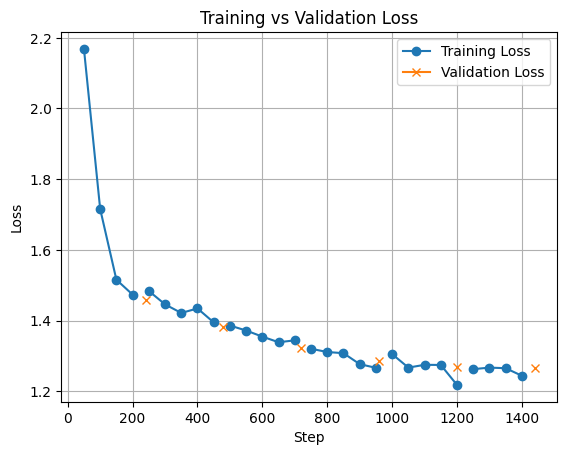

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(trainer.state.log_history)

# Optional: Save to CSV
df.to_csv("/mnt/data/loss_history1.csv", index=False)

# Plotting
plt.plot(df["step"], df["loss"], label="Training Loss", marker='o')
plt.plot(df["step"], df["eval_loss"], label="Validation Loss", marker='x')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

In [17]:
# Save Final Model
print(" Saving model...")
trainer.save_model(f"{output_dir}/final")
tokenizer.save_pretrained(f"{output_dir}/final")

💾 Saving model...


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


('/mnt/data/llama2_qa_lora_output3/final/tokenizer_config.json',
 '/mnt/data/llama2_qa_lora_output3/final/special_tokens_map.json',
 '/mnt/data/llama2_qa_lora_output3/final/tokenizer.model',
 '/mnt/data/llama2_qa_lora_output3/final/added_tokens.json',
 '/mnt/data/llama2_qa_lora_output3/final/tokenizer.json')

In [18]:
def clean_prediction(raw_text):
    answer = raw_text.split("[/INST]")[-1].strip()
    answer = re.sub(r"[^\w\s\-.,:/()]", "", answer)
    return answer.strip()

In [20]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, StoppingCriteria, StoppingCriteriaList
from datasets import Dataset
import evaluate
import pandas as pd
from tqdm import tqdm
import re

# --- Reload model and tokenizer ---
model_path = "/mnt/data/llama2_qa_lora_output3/final" 
print(" Loading fine-tuned model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

# Define a custom stopping criteria
class StopOnNewline(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        return input_ids[0, -1] == 13 # Token ID for newline

stopping_criteria = StoppingCriteriaList([StopOnNewline()])

# Create the pipeline
qa_pipeline = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer
)

# Load the test dataset

def extract_prompt_and_answer(entry):
    try:
        text = entry["text"]
        parts = text.split("[/INST]")
        prompt = parts[0] + "[/INST]"
        reference = parts[1].strip().replace("</s>", "")
        return {"prompt": prompt, "reference": reference}
    except Exception:
        return {"prompt": "", "reference": ""}

print(" Processing test set...")
processed = [extract_prompt_and_answer(ex) for ex in test_dataset]
processed = [ex for ex in processed if ex["prompt"].strip() and ex["reference"].strip()]

# Inferenc
print(" Generating predictions with aggressive post-processing...")
predictions = []
batch_size = 4

for i in tqdm(range(0, len(processed), batch_size)):
    batch_prompts = [ex["prompt"] for ex in processed[i:i + batch_size]]
    
    batch_outputs = qa_pipeline(
        batch_prompts, 
        max_new_tokens=256,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        stopping_criteria=stopping_criteria
    )

    for out in batch_outputs:
        gen_text = out[0]["generated_text"]
        cleaned_answer = clean_prediction(gen_text)
        predictions.append(cleaned_answer)
# Evaluation using SQuAD metric
print("📊 Calculating metrics...")
references = [ex["reference"] for ex in processed]
squad_metric = evaluate.load("squad")

formatted_preds = [{"id": str(i), "prediction_text": p} for i, p in enumerate(predictions)]
formatted_refs = [{"id": str(i), "answers": {"text": [r], "answer_start": [0]}} for i, r in enumerate(references)]

results = squad_metric.compute(predictions=formatted_preds, references=formatted_refs)
print(f"\n✅ Exact Match (EM): {results['exact_match']:.2f}")
print(f"📈 F1 Score: {results['f1']:.2f}")

# Save Detailed CSV
df = pd.DataFrame({
    "id": list(range(len(predictions))),
    "prompt": [ex["prompt"] for ex in processed],
    "reference": references,
    "prediction": predictions
})
df["exact_match"] = [squad_metric.compute(predictions=[formatted_preds[i]], references=[formatted_refs[i]])["exact_match"] for i in range(len(predictions))]
df["f1"] = [squad_metric.compute(predictions=[formatted_preds[i]], references=[formatted_refs[i]])["f1"] for i in range(len(predictions))]
csv_path = "/mnt/data/Third Implementation/test_dataset_eval_results_FINAL.csv"
df.to_csv(csv_path, index=False)
print(f" Detailed test set results saved to: {csv_path}")

🧠 Loading fine-tuned model and tokenizer...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


📝 Processing test set...
🔮 Generating predictions with aggressive post-processing...


  0%|                                                    | 0/54 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
  2%|▊                                           | 1/54 [00:08<07:49,  8.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` 

📊 Calculating metrics...

✅ Exact Match (EM): 9.86
📈 F1 Score: 27.22
✅ Detailed test set results saved to: /mnt/data/Third Implementation/test_dataset_eval_results_FINAL.csv
